# Dungen Wall Finder
A project to generate wall data from dungeon maps for tabletop rpgs and export them to a module which can be used with the Fantasy Grounds program. 

The basic idea to start: 

1) Enter a image

2) tile the image into 8x8 (or 16x16) (or 32x32) pixel tiles

3) Use a pretrained classification NN to identify if the tile contains a wall (and later window/obstacle etc.).

4) Construct wall coordinates by placing a wall ponit in the middle of the tile

5) See which wall tiles are adjacent

6) From them construct the xml string used in a Fantasy Grounds module

7) Either continue for a new image or terminate

8) Construct a Fantasy Grounds module after all images are processed

For this we will need a training data set of tiles, divided into the categories in different subfolders.

We will then use TensorFlow/Keras to construct the NN and train it and see which tile size gives us the best result. 

We will start with a simple black and white dungeon map. 

This jupyter notebook will be used for a proof of concept of the NN part.

Fot the NN we followed [keras.io](https://keras.io/examples/vision/image_classification_from_scratch/) for a start


## Load the example and divide into tiles

In [1]:
filename = 'data/example_map.png'
tile_size = 128

In [2]:
from PIL import Image

In [3]:
img = Image.open(filename)

In [4]:
width, height = img. size

In [5]:
#for x0 in range(0, width, tile_size):
#    for y0 in range(0, height, tile_size):
#        box = (x0, y0,
#              x0 + tile_size if x0+tile_size < width else width -1,
#              y0 + tile_size if y0+tile_size < height else height -1)
#        print('%s %s' % (filename, box))
#        img.crop(box).save('tile.%s.x%03d.y%03d.png' % (filename.replace('.png',''), x0, y0))

## Preparing the NN
### Setup

In [6]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [7]:
# Generate a Dataset

image_size = (tile_size, tile_size)
batch_size = 32
foldername = 'data/'+str(tile_size)

# The following needs at least tensorflow 2.3.0
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    foldername,
    validation_split = 0.2,
    subset='training',
    seed=1337,
    image_size=image_size,
    batch_size=batch_size
)
validation_ds = tf.keras.preprocessing.image_dataset_from_directory(
    foldername,
    validation_split = 0.2,
    subset='validation',
    seed=1337,
    image_size=image_size,
    batch_size=batch_size
)

Found 108 files belonging to 2 classes.
Using 87 files for training.
Found 108 files belonging to 2 classes.
Using 21 files for validation.


### Visualize the data

In [8]:
import matplotlib.pyplot as plt

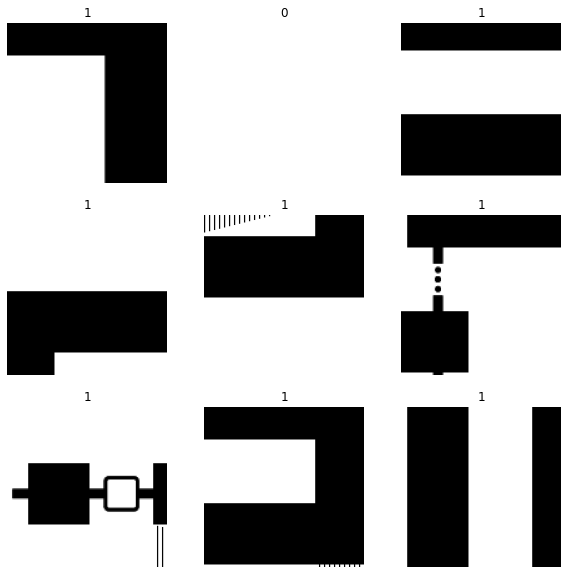

In [9]:
plt.figure(figsize=(10,10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

### Data Preprocessing
Normalizing the rgb values to `[0,1]` to benefit the NN

In [10]:
# This is done during the model run

### Build a model

In [19]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    #x = data_augmentation(inputs)

    # Entry block
    x = inputs
    x = layers.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)

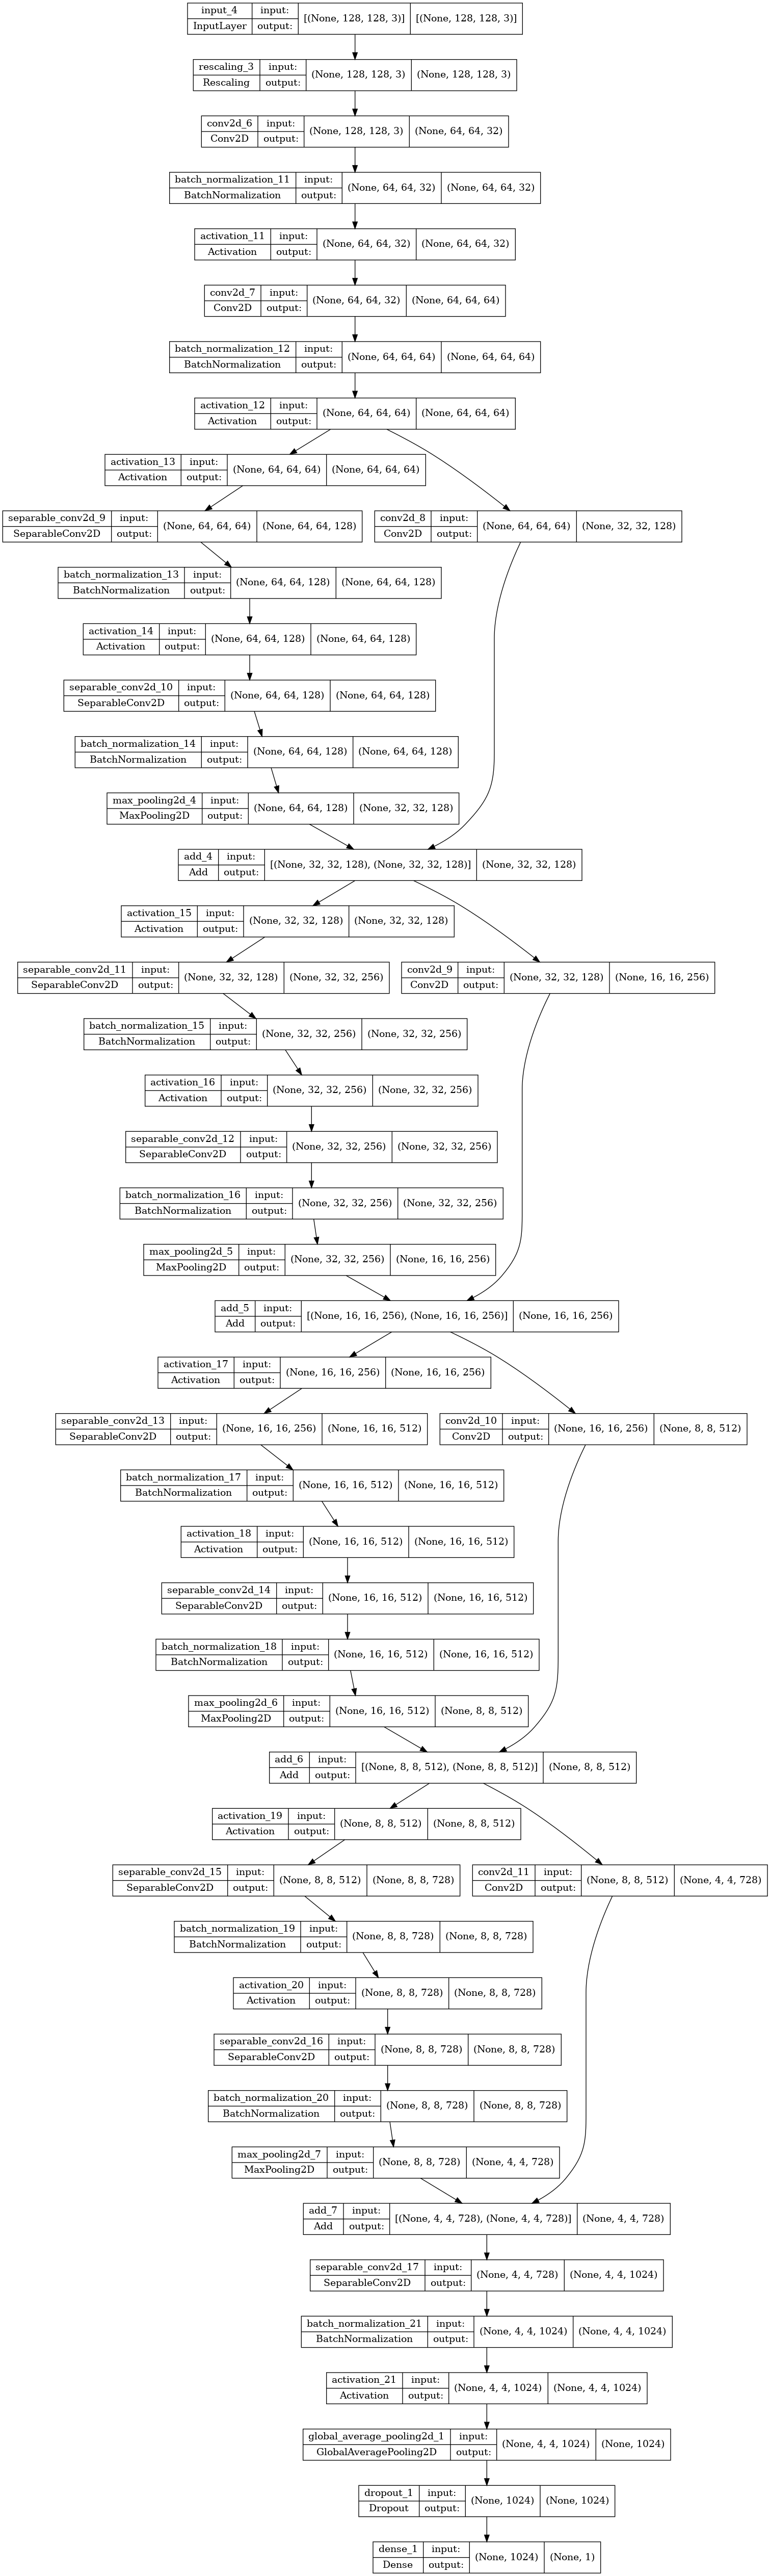

In [20]:
model = make_model(input_shape=image_size + (3,), num_classes=2)
keras.utils.plot_model(model, show_shapes=True)

In [23]:
epochs = 50

callbacks =[
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss='binary_crossentropy',
    metrics='accuracy',
)
model.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=validation_ds,
)

Epoch 1/50
3/3 [==============================] - 5s 1s/step - loss: 0.5119 - accuracy: 0.7356 - val_loss: 0.6719 - val_accuracy: 0.8571
Epoch 2/50
3/3 [==============================] - 4s 1s/step - loss: 0.2512 - accuracy: 0.9540 - val_loss: 0.6581 - val_accuracy: 0.8571
Epoch 3/50
3/3 [==============================] - 4s 1s/step - loss: 0.1519 - accuracy: 0.9195 - val_loss: 0.6456 - val_accuracy: 0.8571
Epoch 4/50
3/3 [==============================] - 3s 1s/step - loss: 0.0915 - accuracy: 0.9655 - val_loss: 0.6414 - val_accuracy: 0.8571
Epoch 5/50
3/3 [==============================] - 4s 1s/step - loss: 0.0342 - accuracy: 1.0000 - val_loss: 0.6387 - val_accuracy: 0.8571
Epoch 6/50
3/3 [==============================] - 4s 1s/step - loss: 0.0740 - accuracy: 0.9770 - val_loss: 0.6356 - val_accuracy: 0.8571
Epoch 7/50
3/3 [==============================] - 4s 1s/step - loss: 0.0270 - accuracy: 1.0000 - val_loss: 0.6344 - val_accuracy: 0.8571
Epoch 8/50
3/3 [=========================

## Testing the NN

In [38]:
img = keras.preprocessing.image.load_img(
    './data/128/wall/tile.example_map.x000.y640.png', target_size=image_size
)
img_array = keras.preprocessing.image.img_to_array(img)


(-0.5, 127.5, 127.5, -0.5)

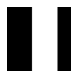

In [39]:

# Plot the Image
ax = plt.subplot(3, 3, i+1)
plt.imshow(img)
plt.axis("off")

In [27]:
img_array = tf.expand_dims(img_array,0)

In [28]:
predictions = model.predict(img_array)

In [29]:
score = predictions[0]

In [36]:
print(
"This image contains a wall with %.2f percent confidence"
% (100 * (1 - score)))

This image contains a wall with 87.57 percent confidence
